In [2]:
import pyspark as ps

In [3]:
from pyspark.sql.types import *

In [4]:
from pyspark.sql import functions as func
from pyspark.sql.window import Window

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [6]:
import requests 
import pprint
import json

In [8]:
r = requests.get('https://api.opendota.com/api/heroes')
hero_list = json.loads(r.text)


hero_df = pd.DataFrame(hero_list)
hero_df.drop(['name','primary_attr','legs'],axis=1,inplace = True)
hero_df.head()

,id,localized_name,attack_type,roles
0,1,Anti-Mage,Melee,"[Carry, Escape, Nuker]"
1,2,Axe,Melee,"[Initiator, Durable, Disabler, Jungler]"
2,3,Bane,Ranged,"[Support, Disabler, Nuker, Durable]"
3,4,Bloodseeker,Melee,"[Carry, Disabler, Jungler, Nuker, Initiator]"
4,5,Crystal Maiden,Ranged,"[Support, Disabler, Nuker, Jungler]"


In [9]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[2]')
         .appName('capstone')
         .getOrCreate()
        )

In [10]:
samples_eda = spark.read.csv('players_larger_sample.csv',
                             header = True,
                             sep=',',
                             inferSchema=True)

In [11]:
samples_eda.cache()

DataFrame[match_id: bigint, account_id: bigint, player_slot: int, hero_id: int, item_0: int, item_1: int, item_2: int, item_3: int, item_4: int, item_5: int, kills: int, deaths: int, assists: int, leaver_status: int, gold: int, last_hits: int, denies: int, gold_per_min: int, xp_per_min: int, gold_spent: int, hero_damage: int, tower_damage: int, hero_healing: int, level: int, additional_units: string, stuns: string, max_hero_hit: string, times: string, gold_t: string, lh_t: string, xp_t: string, obs_log: string, sen_log: string, purchase_log: string, kills_log: string, buyback_log: string, lane_pos: string, obs: string, sen: string, actions: string, pings: string, purchase: string, gold_reasons: string, xp_reasons: string, killed: string, item_uses: string, ability_uses: string, hero_hits: string, damage: string, damage_taken: string, damage_inflictor: string, runes: string, killed_by: string, kill_streaks: string, multi_kills: string, life_state: string]

In [15]:
samples_eda.select([func.count(func.when(func.col(c).isNull(), c)).alias(c) for c in samples_eda.columns]).show()

+--------+----------+-----------+-------+------+------+------+------+------+------+-----+------+-------+-------------+-------+---------+------+------------+----------+----------+-----------+------------+------------+-----+----------------+-------+------------+-------+-------+-------+-------+-------+-------+------------+---------+-----------+--------+-------+-------+-------+-------+--------+------------+----------+-------+---------+------------+---------+-------+------------+----------------+-------+---------+------------+-----------+----------+
|match_id|account_id|player_slot|hero_id|item_0|item_1|item_2|item_3|item_4|item_5|kills|deaths|assists|leaver_status|   gold|last_hits|denies|gold_per_min|xp_per_min|gold_spent|hero_damage|tower_damage|hero_healing|level|additional_units|  stuns|max_hero_hit|  times| gold_t|   lh_t|   xp_t|obs_log|sen_log|purchase_log|kills_log|buyback_log|lane_pos|    obs|    sen|actions|  pings|purchase|gold_reasons|xp_reasons| killed|item_uses|ability_uses|h

In [ ]:
df_players_samples_eda = samples_eda.select('hero_id','kills','deaths','assists','gold_per_min','xp_per_min')

In [ ]:
df_players_samples_eda.createOrReplaceTempView("stats")

query = """
SELECT 
    hero_id,
    CAST((SUM(kills))/SUM(deaths) as decimal(5,2)) as kd_ratio,
    CAST((SUM(assists))/SUM(deaths) as decimal(5,2)) as ad_ratio,
    CAST(AVG(kills) as decimal(5,2)) as average_kills,
    CAST(AVG(deaths) as decimal(5,2)) as average_deaths,
    CAST(AVG(assists) as decimal(5,2)) as average_assists,
    CAST(AVG(gold_per_min) as decimal(20,2)) as average_gold,
    CAST(AVG(xp_per_min) as decimal(5,2)) as average_xp,
    COUNT(hero_id) as freq
FROM stats
GROUP BY hero_id
ORDER BY 
    freq DESC, 
    kd_ratio DESC
"""
#spark.sql(query).show(5)
eda_query = spark.sql(query)

In [290]:
eda_query.show(5)

+-------+--------+--------+-------------+--------------+---------------+------------+----------+-----+
|hero_id|kd_ratio|ad_ratio|average_kills|average_deaths|average_assists|average_gold|average_xp| freq|
+-------+--------+--------+-------------+--------------+---------------+------------+----------+-----+
|     14|    1.27|    1.11|         9.32|          7.35|           8.19|      898.39|    558.89|35634|
|     35|    1.06|    1.13|         7.16|          6.74|           7.64|      952.12|    558.24|30918|
|      6|    0.86|    0.86|         6.21|          7.22|           6.18|      943.95|    557.62|28480|
|     32|    1.57|    1.12|         9.67|          6.15|           6.89|      712.82|    550.17|24722|
|     44|    0.91|    0.96|         6.48|          7.09|           6.79|     1094.69|    595.91|24605|
+-------+--------+--------+-------------+--------------+---------------+------------+----------+-----+
only showing top 5 rows



In [291]:
eda_query.select([func.count(func.when(func.col(c).isNull(), c)).alias(c) for c in eda_query.columns]).show()

+-------+--------+--------+-------------+--------------+---------------+------------+----------+----+
|hero_id|kd_ratio|ad_ratio|average_kills|average_deaths|average_assists|average_gold|average_xp|freq|
+-------+--------+--------+-------------+--------------+---------------+------------+----------+----+
|      0|       1|       1|            0|             0|              0|           0|         0|   0|
+-------+--------+--------+-------------+--------------+---------------+------------+----------+----+



In [292]:
eda_query.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|           hero_id|          kd_ratio|           ad_ratio|     average_kills|    average_deaths|   average_assists|      average_gold|       average_xp|             freq|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|               112|               111|                111|               112|               112|               112|               112|              112|              112|
|   mean|56.330357142857146|          0.817748|           1.322072|          5.647679|          6.959643|          9.170089|        729.049911|       481.850536|       10168.1875|
| stddev|32.844264899800045|0.2225296085904676|0.31625684934621523|1.5916091818171911|0.994155831470

In [293]:
hyp_test_info = eda_query.describe().toPandas()

In [294]:
eda_query = eda_query.withColumn('percent',func.col('freq')/func.sum('freq').over(Window.partitionBy()))
#eda_query.show()

In [295]:
eda_query.show(5)

+-------+--------+--------+-------------+--------------+---------------+------------+----------+-----+--------------------+
|hero_id|kd_ratio|ad_ratio|average_kills|average_deaths|average_assists|average_gold|average_xp| freq|             percent|
+-------+--------+--------+-------------+--------------+---------------+------------+----------+-----+--------------------+
|     14|    1.27|    1.11|         9.32|          7.35|           8.19|      898.39|    558.89|35634|0.031289815838438685|
|     35|    1.06|    1.13|         7.16|          6.74|           7.64|      952.12|    558.24|30918| 0.02714874911861838|
|      6|    0.86|    0.86|         6.21|          7.22|           6.18|      943.95|    557.62|28480|0.025007968655742657|
|     32|    1.57|    1.12|         9.67|          6.15|           6.89|      712.82|    550.17|24722| 0.02170811099393504|
|     44|    0.91|    0.96|         6.48|          7.09|           6.79|     1094.69|    595.91|24605|0.021605374605847896|
+-------

In [296]:
pd_eda = eda_query.toPandas()

In [297]:
pd_eda.describe()

,hero_id,freq,percent
count,112.000000,112.000000,112.000000
mean,56.330357,10168.187500,0.008929
std,32.844265,6598.429643,0.005794
min,0.000000,60.000000,0.000053
25%,28.750000,5691.500000,0.004998
50%,56.500000,8752.000000,0.007685
75%,84.250000,13533.000000,0.011883
max,113.000000,35634.000000,0.031290


In [298]:
pd_eda['percent'] = pd_eda['percent'].apply(lambda x: f'{float(x):.3f}')

In [299]:
pd_eda.head()

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent
0,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031
1,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027
2,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025
3,32,1.57,1.12,9.67,6.15,6.89,712.82,550.17,24722,0.022
4,44,0.91,0.96,6.48,7.09,6.79,1094.69,595.91,24605,0.022


In [300]:
pd_eda.isna().sum()

hero_id            0
kd_ratio           1
ad_ratio           1
average_kills      0
average_deaths     0
average_assists    0
average_gold       0
average_xp         0
freq               0
percent            0
dtype: int64

In [301]:
pd_eda[pd_eda.isnull().any(axis=1)]

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent
60,0,None,None,0.00,0.00,0.00,331.51,0.08,8208,0.007


In [448]:
## To be moved upwards
## Remove afterwards



,id,localized_name,attack_type,roles
0,1,Anti-Mage,Melee,"[Carry, Escape, Nuker]"
1,2,Axe,Melee,"[Initiator, Durable, Disabler, Jungler]"
2,3,Bane,Ranged,"[Support, Disabler, Nuker, Durable]"
3,4,Bloodseeker,Melee,"[Carry, Disabler, Jungler, Nuker, Initiator]"
4,5,Crystal Maiden,Ranged,"[Support, Disabler, Nuker, Jungler]"


In [460]:
## To be moved upwards
## Remove afterwards
hero_df = pd.DataFrame(hero_list)
hero_df.drop(['name','primary_attr','legs'],axis=1,inplace = True)
hero_df['roles'] = hero_df['roles'].apply(lambda x: x[0])
hero_df.head()

,id,localized_name,attack_type,roles
0,1,Anti-Mage,Melee,Carry
1,2,Axe,Melee,Initiator
2,3,Bane,Ranged,Support
3,4,Bloodseeker,Melee,Carry
4,5,Crystal Maiden,Ranged,Support


In [444]:
hero_df_multi_roles = hero_df.explode('roles')

In [445]:
len(hero_df)

119

In [451]:
role_labels = {}
n=1
for i in hero_df_multi_roles['roles'].unique():
    role_labels[i] = n
    n += 1

In [461]:
hero_df['role_idx'] = hero_df['roles'].map(role_labels)
hero_df_multi_roles['role_idx']= hero_df_multi_roles['roles'].map(role_labels)

In [416]:
pd_eda.drop(index=60) # index 60 is not part of the playable character from the above API.

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent
0,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031
1,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027
2,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025
3,32,1.57,1.12,9.67,6.15,6.89,712.82,550.17,24722,0.022
4,44,0.91,0.96,6.48,7.09,6.79,1094.69,595.91,24605,0.022
...,...,...,...,...,...,...,...,...,...,...
107,110,0.68,2.11,5.62,8.30,17.48,353.34,395.89,122,0.000
108,112,0.54,1.78,4.13,7.69,13.68,324.90,360.79,77,0.000
109,111,0.88,1.93,7.10,8.04,15.56,312.06,338.65,72,0.000
110,109,0.77,1.33,6.30,8.23,10.93,436.17,452.62,69,0.000


In [467]:
df_top_exploded = pd.merge(pd_eda,hero_df_multi_roles,
              left_on = 'hero_id',
              right_on = 'id',
              how = 'inner').drop('id',axis=1).loc[0:19]

df_rest_exploded = pd.merge(pd_eda,hero_df_multi_roles,
              left_on = 'hero_id',
              right_on = 'id',
              how = 'inner').drop('id',axis=1).loc[20:]

df_top_unexploded = pd.merge(pd_eda,hero_df,
              left_on = 'hero_id',
              right_on = 'id',
              how = 'inner').drop('id',axis=1).loc[0:19]

df_rest_unexploded = pd.merge(pd_eda,hero_df,
              left_on = 'hero_id',
              right_on = 'id',
              how = 'inner').drop('id',axis=1).loc[20:]

In [468]:
cols = ['kd_ratio', 'ad_ratio', 'average_kills', 'average_deaths','average_assists', 
        'average_gold', 'average_xp', 'freq', 'percent']

df_top_exploded[cols] = df_top_exploded[cols].apply(pd.to_numeric, errors = 'coerce')
df_rest_exploded[cols] = df_rest_exploded[cols].apply(pd.to_numeric, errors = 'coerce')

df_top_unexploded[cols] = df_top_unexploded[cols].apply(pd.to_numeric, errors = 'coerce')
df_rest_unexploded[cols] = df_rest_unexploded[cols].apply(pd.to_numeric, errors = 'coerce')

In [471]:
df_top_unexploded['hero_id'].sum()

815

In [472]:
df_top_exploded['hero_id'].sum()

349

In [474]:
df_top_unexploded.head(10)

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent,localized_name,attack_type,roles,role_idx
0,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Disabler,6
1,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027,Sniper,Ranged,Carry,1
2,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Carry,1
3,32,1.57,1.12,9.67,6.15,6.89,712.82,550.17,24722,0.022,Riki,Melee,Carry,1
4,44,0.91,0.96,6.48,7.09,6.79,1094.69,595.91,24605,0.022,Phantom Assassin,Melee,Carry,1
5,4,1.19,1.04,8.67,7.28,7.59,831.63,580.13,22734,0.020,Bloodseeker,Melee,Carry,1
6,1,0.62,0.68,3.92,6.31,4.29,1438.95,600.10,22635,0.020,Anti-Mage,Melee,Carry,1
7,26,0.63,0.95,4.69,7.45,7.06,1308.33,576.96,22534,0.020,Lion,Ranged,Support,8
8,27,0.52,0.94,3.99,7.68,7.23,1564.45,578.45,19695,0.017,Shadow Shaman,Ranged,Support,8
9,62,1.08,1.04,7.24,6.71,7.00,608.88,476.65,19032,0.017,Bounty Hunter,Melee,Escape,2


In [475]:
df_top_exploded.head(10)

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent,localized_name,attack_type,roles,role_idx
0,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Disabler,6
1,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Initiator,4
2,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Durable,5
3,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Nuker,3
4,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027,Sniper,Ranged,Carry,1
5,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027,Sniper,Ranged,Nuker,3
6,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Carry,1
7,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Disabler,6
8,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Pusher,9
9,32,1.57,1.12,9.67,6.15,6.89,712.82,550.17,24722,0.022,Riki,Melee,Carry,1


In [437]:
df_top.head(20)

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent,localized_name,attack_type,roles,role_idx
0,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Disabler,6
1,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Initiator,4
2,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Durable,5
3,14,1.27,1.11,9.32,7.35,8.19,898.39,558.89,35634,0.031,Pudge,Melee,Nuker,3
4,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027,Sniper,Ranged,Carry,1
5,35,1.06,1.13,7.16,6.74,7.64,952.12,558.24,30918,0.027,Sniper,Ranged,Nuker,3
6,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Carry,1
7,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Disabler,6
8,6,0.86,0.86,6.21,7.22,6.18,943.95,557.62,28480,0.025,Drow Ranger,Ranged,Pusher,9
9,32,1.57,1.12,9.67,6.15,6.89,712.82,550.17,24722,0.022,Riki,Melee,Carry,1


In [1]:
fig,ax = plt.subplots()

labels = ['Top 20 Characters', 'Remaining 99 Characters']
explode = (0.1,0)
sizes = [0.38, 0.62]

ax.pie([df_top_unexploded['percent'].sum(), 1-df_top['percent'].sum()],
      explode = explode,
      labels = labels,
      startangle = 90,
      autopct = '%1.1f%%')

ax.axis('equal')
ax.set_title('Character Selections by Sample Players')
plt.show()

NameError: name 'plt' is not defined

In [414]:
df_top.groupby('attack_type').mean()

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent,role_idx
attack_type,,,,,,,,,,,
Melee,45.583333,1.019167,1.059167,6.9650,6.855833,7.23750,912.546667,554.480,20626.833333,0.018167,1.666667
Ranged,33.500000,0.772500,1.092500,5.3075,6.980000,7.51375,1148.777500,570.715,21158.250000,0.018500,1.500000


In [415]:
df_rest.groupby('attack_type').mean()

,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent,role_idx
attack_type,,,,,,,,,,,
Melee,64.775000,0.774750,1.370750,5.356500,6.956750,9.491250,691.717500,482.53800,8120.225000,0.007150,1.950000
Ranged,56.921569,0.811176,1.381765,5.730196,7.119608,9.812549,657.109804,459.72902,7628.078431,0.006706,2.235294


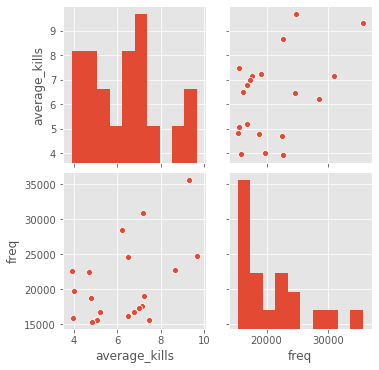

In [394]:
sns.pairplot(df_top, vars = ['average_kills','freq'])

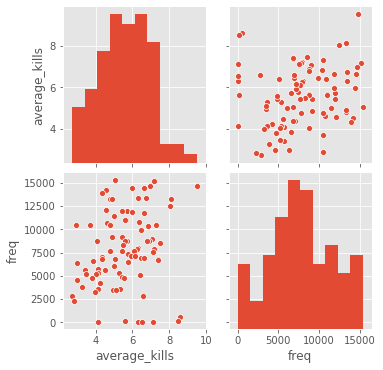

In [397]:
sns.pairplot(df_rest, vars = ['average_kills','freq'])

(array([3., 3., 2., 1., 3., 4., 1., 0., 1., 2.]),
 array([3.92 , 4.495, 5.07 , 5.645, 6.22 , 6.795, 7.37 , 7.945, 8.52 ,
        9.095, 9.67 ]),
 <a list of 10 Patch objects>)

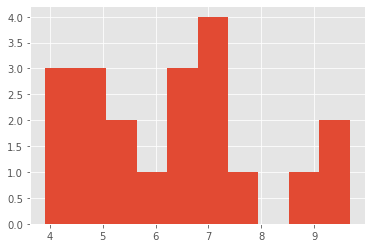

In [421]:
fig,ax = plt.subplots()
ax.hist(df_top['average_kills'])

(array([ 5.,  1.,  3.,  5.,  8.,  4., 11.,  5., 11.,  4.,  8.,  8.,  6.,
         7.,  0.,  2.,  0.,  2.,  0.,  1.]),
 array([2.74 , 3.078, 3.416, 3.754, 4.092, 4.43 , 4.768, 5.106, 5.444,
        5.782, 6.12 , 6.458, 6.796, 7.134, 7.472, 7.81 , 8.148, 8.486,
        8.824, 9.162, 9.5  ]),
 <a list of 20 Patch objects>)

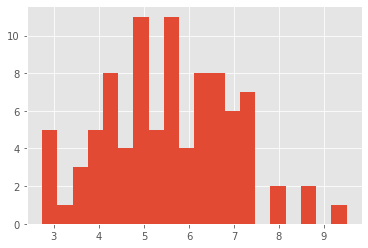

In [382]:
fig,ax = plt.subplots()
ax.hist(df_rest['average_kills'],bins =20)

In [399]:
df_full = df_players_samples_eda.toPandas()
df_full.head()

,hero_id,kills,deaths,assists,gold_per_min,xp_per_min
0,14,19,8,2,338,559
1,32,5,2,9,280,432
2,100,7,19,11,357,411
3,76,7,10,21,438,469
4,86,11,5,36,500,656


In [400]:
df_full['kills'].mean()

5.961161254859124

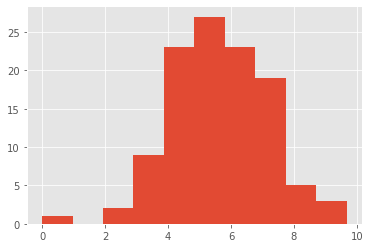

In [411]:
fig,ax = plt.subplots()

ax.hist(df_full.groupby('hero_id').mean()['kills'])
plt.show()

In [ ]:
fig,ax = plt.subplots()

ax.hist(df_full.groupby('hero_id').mean()['kills'])
plt.show()

In [270]:
hyp_test_info

,summary,hero_id,kd_ratio,ad_ratio,average_kills,average_deaths,average_assists,average_gold,average_xp,freq,percent
0,count,112,111,111,112,112,112,97,112,112,112
1,mean,56.330357142857146,0.817748,1.322072,5.647679,6.959643,9.170089,650.650000,481.850536,10168.1875,0.008928571428571433
2,stddev,32.844264899800045,0.2225296085904676,0.31625684934621523,1.5916091818171911,0.9941558314700052,2.4816495878026226,172.18989960215444,83.32312163925705,6598.429643280271,0.0057940070820321704
3,min,0,0.35,0.68,0.00,0.00,0.00,312.06,0.08,60,5.268532722417695E-5
4,max,113,1.57,2.13,9.67,9.97,17.48,987.94,669.90,35634,0.031289815838438685


In [ ]:
sns.distplot()

Null Hypothesis ${H_0}$: Players do not choose a character to maximize their kill counts.


Alternate Hypothesis $H_A$: Players choose a character over another in order to maximize their kill counts.